# EDA Notebook - Exploring bmarket dataset

### Part 1 - Initial EDA

In [1]:
import sqlite3

conn = sqlite3.connect("data/01_raw/bmarket.db")
cursor = conn.cursor()

# sqlite_master exists in all sqlite databases and contains metadata on all tables
cursor.execute("SELECT name FROM sqlite_master")
rows = cursor.fetchall()
for row in rows:
    print(row)

('bank_marketing',)


In [2]:
import pandas as pd

# There's only a singular table, convert it to DataFrame
df = pd.read_sql("SELECT * FROM bank_marketing", conn)
df.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


# Data Cleaning

## Initial Simple Data Cleaning

In [180]:
import matplotlib.pyplot as plt
from scipy import stats

In [81]:
# Renaming columns to a format without spaces
column_renames = {name : name.lower().replace(" ", "_") for name in df.columns}
df_renamed = df.rename(columns=column_renames)
df_renamed.columns

Index(['client_id', 'age', 'occupation', 'marital_status', 'education_level',
       'credit_default', 'housing_loan', 'personal_loan', 'contact_method',
       'campaign_calls', 'previous_contact_days', 'subscription_status'],
      dtype='object')

In [82]:
# First removing the Client ID column
# This data is not needed because ID should not have any actual correlation with subscription status (only coincidental)

df_dropid = df_renamed.drop("client_id", axis=1) 
df_dropid.head(3)

,age,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no


## Age
---
Unrealistic 150 year old outliers (likely data entry errors) found
- Set to -1 and added an extra column denoting if the age was unknown or not (boolean)
---

In [84]:
# AGE
# Conversion from string to int type
df_age = df_dropid.copy()
df_age.age = df_age.age.map(lambda x: int(x.split(" ")[0]))

print(f"Number of null values in age column: {df_age.age.isna().sum()}")    # Checking for any empty age cells
df_age.dtypes

Number of null values in age column: 0


age                       int64
occupation               object
marital_status           object
education_level          object
credit_default           object
housing_loan             object
personal_loan            object
contact_method           object
campaign_calls            int64
previous_contact_days     int64
subscription_status      object
dtype: object

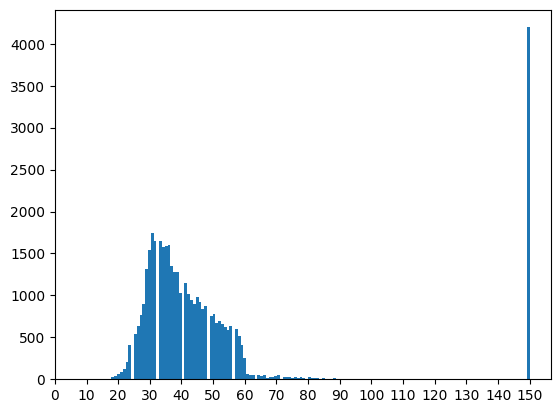

In [85]:
plt.hist(df_age.age, bins=150)
plt.xticks(range(0, 151, 10))
plt.show()

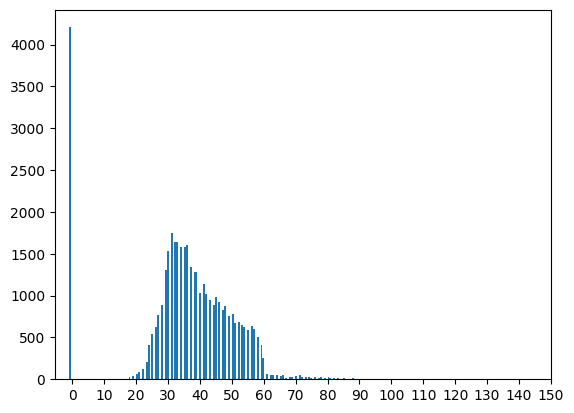

,age,age_unk
0,57,False
1,55,False
2,33,False
3,36,False
4,27,False


In [86]:
"""
Histogram shows a large number of outliers with age = 150, this is likely a data input error
2 solutions: Either clip to max age (~90 years old) or set them as unknown values (-1). 

In this case, it would be best to set them as unknown, since clipping the values would skew the dataset toward the max age,
and ruin the distribution of ages in this dataset.

Solution: Set all ages above 90 years old (outliers) to -1, Create a new boolean column denoting that the age is unknown
"""
df_age.age = df_age.age.map(lambda x: x if x <= 90 else -1)     # Set >90 years old to -1
df_age.insert(loc=df_age.columns.get_loc("age")+1, column="age_unk", value=df_age.age.map(lambda x: False if x <= 90 else True))

plt.hist(df_age.age, bins=150)
plt.xticks(range(0, 151, 10))
plt.show()

df_age.loc[:, ["age", "age_unk"]].head()

## Marital Status
---
Normal, minimal cleaning required

---

In [87]:
df_marital = df_age.copy()
df_marital.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


Number of null values in marital_status column: 0
marital_status
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


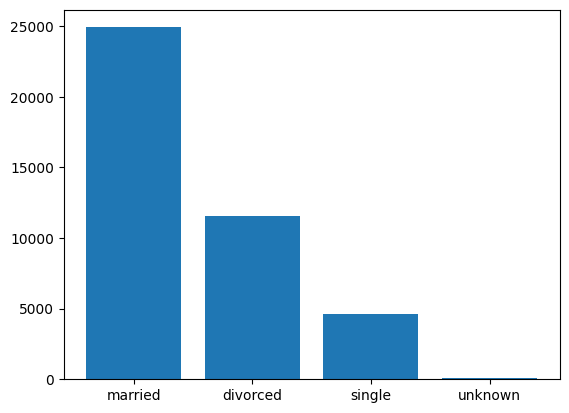

In [ ]:
# Unique values of marital status show no overlap in categorization, so no change is necessary
# No nulls in column
print(f"Number of null values in marital_status column: {df_marital.marital_status.isna().sum()}")
print(df_marital.marital_status.value_counts())
plt.bar(df_marital.marital_status.unique(), df_marital.marital_status.value_counts())
plt.show()

## Education Level
---
Normal, minimal cleaning required

Rare category: illiterate, with only 18 instances in entire dataset

---

In [70]:
df_education = df_marital.copy()
df_education.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


Number of null values in education_level column: 0
education_level
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64


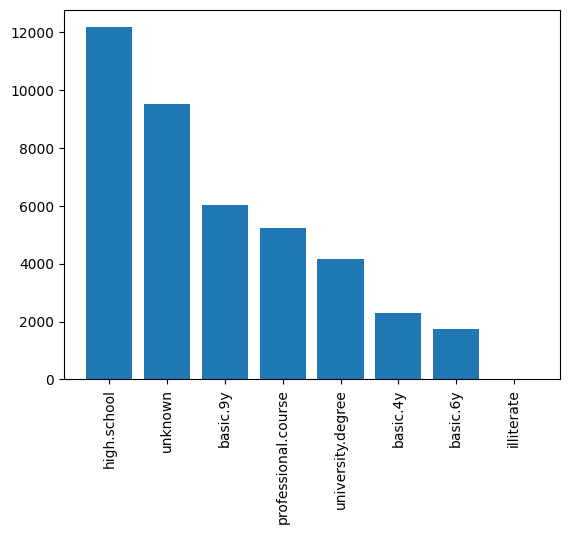

In [95]:
# Unique values of education level show no overlap in categorization, so no change is necessary
# No nulls found
# Small problem with the extremely small amount of data on illiterate education level, but otherwise there is nothing serious that needs to be cleaned.
print(f"Number of null values in education_level column: {df_education.education_level.isna().sum()}")
print(df_education.education_level.value_counts())
plt.bar(df_education.education_level.unique(), df_education.education_level.value_counts())
plt.xticks(rotation=90)
plt.show()

## Credit Default
---
**NONE**

---

In [96]:
df_credit = df_education.copy()
df_credit.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


## Housing Loan
---
**NONE**

---

In [97]:
df_housing = df_credit.copy()
df_housing.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


## Personal Loan
---
**NONE**

---

In [98]:
df_personal = df_housing.copy()
df_personal.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


## Contact Method
---
Categorization overlap: Cell = cellular & Telephone = telephone
- Combined categories (Cell & cellular -> cellular, Telephone & telephone -> telephone)

---

In [ ]:
df_contact = df_personal.copy()
df_contact.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [128]:
# No nulls found
# Categorization overlap with Cell -> cellular & Telephone -> telephone
print(f"Number of null values in contact_method column: {df_contact.contact_method.isna().sum()}")
print(_ := df_contact.contact_method.value_counts())
print(f"\nCellular Category total: {_.iloc[:2].sum()}\nTelephone Category total: {_.iloc[2:].sum()}")

Number of null values in contact_method column: 0
contact_method
Cell         13100
cellular     13044
Telephone     7585
telephone     7459
Name: count, dtype: int64

Cellular Category total: 26144
Telephone Category total: 15044


In [ ]:
# Combining Cell -> cellular & Telephone -> telephone
df_contact.contact_method = df_contact.contact_method.map(lambda x: "cellular" if x[0].lower() == "c" else "telephone")
print(df_contact.contact_method.value_counts())

contact_method
cellular     26144
telephone    15044
Name: count, dtype: int64


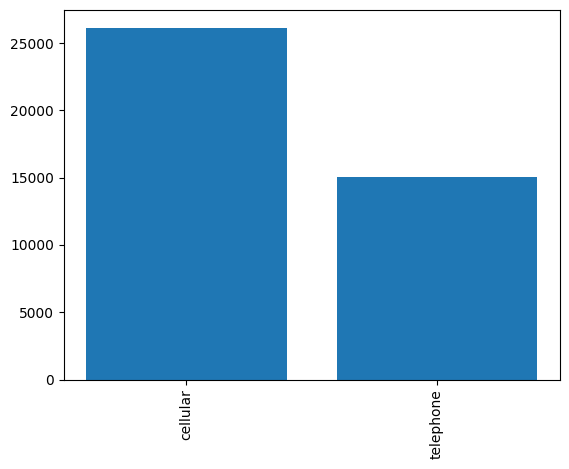

In [130]:
plt.bar(df_contact.contact_method.unique(), df_contact.contact_method.value_counts())
plt.xticks(rotation=90)
plt.show()

## Campaign Calls
---
Categorization overlap: Cell = cellular & Telephone = telephone
- Combined categories (Cell & cellular -> cellular, Telephone & telephone -> telephone)

---

In [131]:
df_campaign = df_contact.copy()
df_campaign.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,cellular,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,cellular,2,999,no


In [ ]:
# No null values
# It looks like campaign calls goes into the negatives, despite it not being possible to have negative campaign calls
print(f"Number of null values in contact_method column: {df_contact.contact_method.isna().sum()}")
df_campaign.campaign_calls.describe()

Number of null values in contact_method column: 0


count    41188.000000
mean         2.051374
std          3.171345
min        -41.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign_calls, dtype: float64

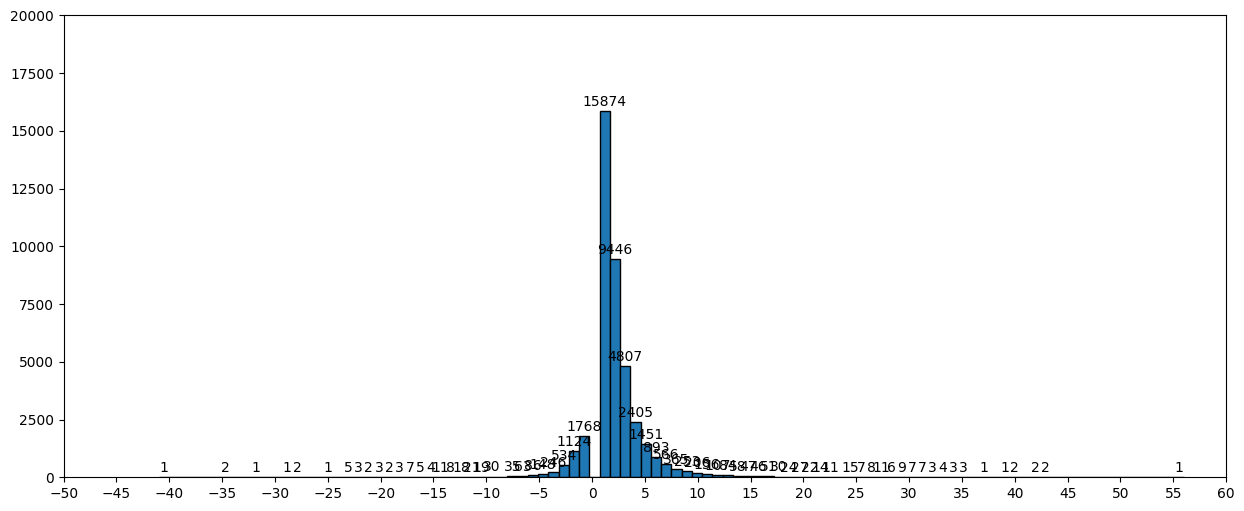

In [176]:
plt.figure(figsize=(15, 6))
counts, bins, patches = plt.hist(df_campaign.campaign_calls, bins=100, edgecolor='black')
# Add value labels
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        plt.text(bin_edge + (bins[1] - bins[0]) / 2, count+100, str(int(count)), ha='center', va='bottom')
plt.xticks(range(-50, 61, 5))
plt.axis([-50, 60, 0, 20000])
plt.show()

In [178]:
print("Count of negative values: ", end="")
print(len(df_campaign[df_campaign.campaign_calls < 0]))

Count of negative values: 4153


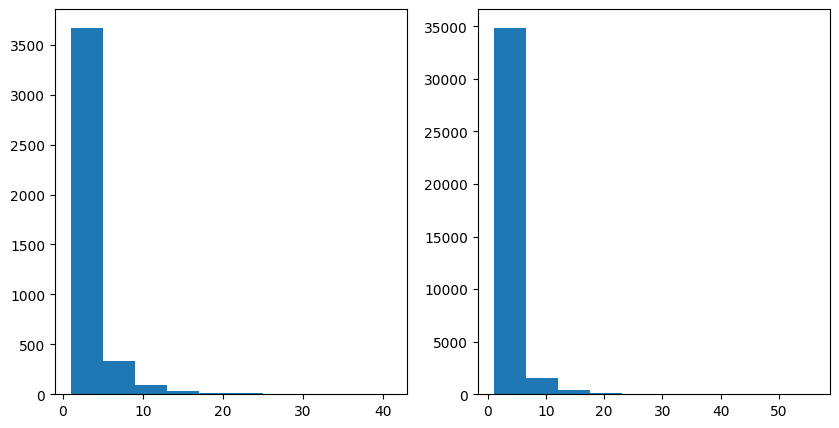

In [ ]:
"""
Based on the histogram, you can see many of the values are in the negatives, despite these values not being possible for this data column.
3 Solutions:
    1. Clip negative values to 0 / lowest campaign calls values > 0
    2. Change all negative values into unknown values
    3. Assume this is a data entry error where positive data was mistakenly changed to negative values

Solution 1: 
    Clipping the negative values will create skewed data, since the histogram already shows that the data is more frequent the smaller the number is.
    Additional ~4,000 data points would be added to the most frequent category, which may negatively affect the generalisation of the final model.

Solution 2:
    Changing all negative values into unknown values will result in losing ~4,000 data points, which can affect the model's ability

Solution 3:
    Based on the histogram above, it does seem that a portion of the positive values were accidentally converted into negative values,
    since the overall distribution in the negative space is similar to that of the positive space.
    Additionally, converting the data this way would allow us to prevent any data loss which would have been caused by the previous solutions.
    The only problem is that this distribution similarity between positive and negative may be coincidental. 
"""

# Calculating similarity of positive and negative space distributions using K-S test
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Negative space
ax[0].hist(neg := df_campaign.campaign_calls[df_campaign.campaign_calls < 0].abs())
# Positive space
ax[1].hist(pos := df_campaign.campaign_calls[df_campaign.campaign_calls > 0])
plt.show()

In [205]:
statistic, p = stats.ks_2samp(neg, pos)
print("K-S Test for samples neg & pos:")
print(f"KS Stat:    {statistic}")
print(f"p-value:    {p}")

print("""
The hypothesis here is that the negative numbers inside the dataset (negative sample), are errors that are caused by accidentally
converting a portion of the positive numbers into negative numbers. This hypothesis can be proven if both the negative and positive
samples are likely taken from the same distribution.

According to the Kolmogorov-Smirnov (KS) test, any p-value (0.5804...) > 0.05 (standard significance level) 
This suggests that there is not enough evidence to reject the Null Hypothesis (Both samples are drawn from the same distribution (neg(x) = pos(x) for all x))
Basically, it is likely that both samples are taken from the same distribution.
      
Considering the hypothesis that the negative numbers are data entry errors that converted positive numbers into negative,
since the negative number sample is very likely from the same distribution as the positive sample, this hypothesis is also very likely to be true.
      
Hence, imputating the erroneuous data within this column by converting negative numbers into positive numbers is very to be the best course of action.
""")

K-S Test for samples neg & pos:
KS Stat:    0.012686471895130724
p-value:    0.5804227545723576

The hypothesis here is that the negative numbers inside the dataset (negative sample), are errors that are caused by accidentally
converting a portion of the positive numbers into negative numbers. This hypothesis can be proven if both the negative and positive
samples are likely taken from the same distribution.

According to the Kolmogorov-Smirnov (KS) test, any p-value (0.5804...) > 0.05 (standard significance level) 
This suggests that there is not enough evidence to reject the Null Hypothesis (Both samples are drawn from the same distribution (neg(x) = pos(x) for all x))
Basically, it is likely that both samples are taken from the same distribution.

Considering the hypothesis that the negative numbers are data entry errors that converted positive numbers into negative,
since the negative number sample is very likely from the same distribution as the positive sample, this hypothesis is